This notebook is a part of ShakesPeer project, CPSC547-19. It contains codes for character-to-character sentiment analysis using AFINN and Bing Liu lexicon with basic output stats calculation and sample visualization.

## Dependencies
- AFINN lexicon (https://pypi.org/project/afinn/)
- Natural Language Toolkit for Bing Liu lexicon (https://www.nltk.org/install.html)
- xlrd for reading Excel spreadsheet (https://pypi.org/project/xlrd/)

In [1]:
from afinn import Afinn
import csv
import xlrd
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [8]:
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to C:\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

### Instantiate functions for sentiment analysis
For AFINN lexicon, the function is built-in afinn.score().
For Bing Liu lexicon, the function blscore() is based on nltk.sentiment.util.demo_liu_hu_lexicon().

In [3]:
def blscore(sentence):
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent)))  # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1)  # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1)  # negative
        else:
            y.append(0)  # neutral

    return pos_words - neg_words

In [4]:
afinn = Afinn()

## Read data

In [5]:
playname = "MND"

In [6]:
# Read data from excel spreadsheet
book = xlrd.open_workbook('dialogue_annotated.xlsx')
sheet = book.sheet_by_name('Sheet 1 - dialogue copy')
characters = []
max_scene = 9 # number of scenes, hardcoded for MND

for i in range(1, sheet.nrows):
    row = sheet.row_values(i)
    speaker = row[0].split(', ')
    recipient = row[2].split(', ')
    for s in speaker:
        if s not in characters:
            characters.append(s)
    for r in recipient:
        if r not in characters:
            characters.append(r)
            
print(characters)

['THESEUS', 'HIPPOLYTA', 'PHILOSTRATE', 'EGEUS', 'LYSANDER', 'HERMIA', 'DEMETRIUS', 'HELENA', 'SELF', 'QUINCE', 'BOTTOM', 'FLUTE', 'STARVELING', 'SNOUT', 'SNUG', 'ROBIN', 'FAIRY', 'OBERON', 'TITANIA', 'FIRST FAIRY', 'SECOND FAIRY', 'NONE', 'CHORUS', 'COBWEB', 'MOTE', 'MUSTARDSEED', 'PEASEBLOSSOM', 'ALL']


In [9]:
# Unrelevant characters
toRemove = ['NONE', 'SELF', 'ALL', 'CHORUS']
for r in toRemove:
    if r in characters:
        characters.remove(r)
print(characters)

['THESEUS', 'HIPPOLYTA', 'PHILOSTRATE', 'EGEUS', 'LYSANDER', 'HERMIA', 'DEMETRIUS', 'HELENA', 'QUINCE', 'BOTTOM', 'FLUTE', 'STARVELING', 'SNOUT', 'SNUG', 'ROBIN', 'FAIRY', 'OBERON', 'TITANIA', 'FIRST FAIRY', 'SECOND FAIRY', 'COBWEB', 'MOTE', 'MUSTARDSEED', 'PEASEBLOSSOM']


## Sentiment Analysis

In [10]:
def scene_num(n):
    """ Because there was a problem reading in scene number from spreadsheet. """
    if n < 60:
        return 0
    elif n < 105:
        return 1
    elif n < 144:
        return 2
    elif n < 173:
        return 3
    elif n < 247:
        return 4
    elif n < 364:
        return 5
    elif n < 426:
        return 6
    elif n < 440:
        return 7
    else:
        return 8

In [19]:
def valueRange(D, DE):
    """ Calculate min amd max of sentiment and engagement value """

    maxSentiment = 0
    minSentiment = 0
    maxEngagement = 0

    for key in D:
        maxS = max(D[key])
        minS = min(D[key])
        maxE = max(DE[key])
        if maxS > maxSentiment:
            maxSentiment = maxS
        if minS < minSentiment:
            minSentiment = minS
        if maxE > maxEngagement:
            maxEngagement = maxE
    
    return maxSentiment, minSentiment, maxEngagement

In [12]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [13]:
def plotSentiment(AB, BA, ABE, BAE, ABLabel, BALabel):
    """ Plot bar charts for each pair of characters with grey background region indicating scenes without engagement.
        Input: AB = list of sentiment by scene from character A to B
               BA = list of sentiment by scene from character B to A
               ABE = list of engagement by scene from A to B
               BAE = list of engagement by scene from B to A
               ABLabel = A's name - B's name (string)
               BALabel = B's name - A's name (string)"""
    
    labels = list(range(1, 10))
    x = np.arange(len(AB))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, AB, width, label=ABLabel)
    rects2 = ax.bar(x + width/2, BA, width, label=BALabel)
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_ylim(-36, 36)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
  
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    
    for i in range(len(AB)):
        if ABE[i] == 0 and BAE[i] == 0:
            plt.axvspan(i-0.5, i+0.5, color='gray', alpha=0.5)
    
    fig.tight_layout()
    plt.show()

In [14]:
def plotSentimentDict(D, DE, c, plot=False):
    """ Plot all sentiments in a dictionary and check for data sparsity. 
        Input: D = Dictionary of sentiment
               DE = Dictionary of engagement
               c = list of characters
               plot = True if wants to see sample visualization.
        Output: countPlot = total number of plots
                countZeroPlot = total number of plots where all sentiment valence are 0
                countZeroPoints = total number of bar charts with value 0 """
    
    countPlot = 0
    countZeroPlot = 0
    countZeroPoints = 0
    for ci1 in range(len(c)):
        for ci2 in range(ci1+1, len(c)):
            c1 = characters[ci1]
            c2 = characters[ci2]
            if (c1, c2) in D:
                if (c2, c1) in D: # Case there is nonzero engagement in both direction
                    countPlot += 1
                    if plot:
                        plotSentiment(D[(c1, c2)], D[(c2, c1)], DE[(c1, c2)], DE[(c2, c1)], c1+"-"+c2, c2+"-"+c1)
                    countZeroPoints += (D[(c1, c2)].count(0) + D[(c2, c1)].count(0))
                    if D[(c1, c2)] == [0]*max_scene and D[(c2, c1)] == [0]*max_scene:
                        countZeroPlot += 1
                else: # Case where there's nonzero engagement only from c1 to c2
                    countPlot += 1
                    if plot:
                        plotSentiment(D[(c1, c2)], [0]*max_scene, DE[(c1, c2)], [0]*max_scene, c1+"-"+c2, c2+"-"+c1)
                    countZeroPoints += D[(c1, c2)].count(0)
                    if D[(c1, c2)] == [0]*max_scene:
                        countZeroPlot += 1
            else: # Case where there's nonzero engagement only from c2 to c1
                if (c2, c1) in D:
                    countPlot += 1
                    if plot:
                        plotSentiment([0]*max_scene, D[(c2, c1)], [0]*max_scene, DE[(c2, c1)], c1+"-"+c2, c2+"-"+c1)
                    countZeroPoints += D[(c2, c1)].count(0)
                    if D[(c2, c1)] == [0]*max_scene:
                        countZeroPlot += 1
                        
    return countPlot, countZeroPlot, countZeroPoints

### AFINN lexicon

In [15]:
# Initialize sentiment and engagement dictionary. Each item in S is an array that contains 
# the sentiment valence is each scene. Each item in SE is an array that contains the number of words
# spoken between the pair of characters in each scene.
# Example: in case of MND, there are 9 scenes, so every item is initialized as [0, 0, 0, 0, 0, 0, 0, 0, 0]

S = {}
SE = {}
for c1 in characters:
    for c2 in characters:
        if c1 != c2:
            S[(c1, c2)] = [0]*max_scene
            SE[(c1, c2)] = [0]*max_scene

In [16]:
# calculate sentiment valence for each dialogue and accumulate in dictionary
for i in range(1, sheet.nrows):
    row = sheet.row_values(i)
    speaker = row[0].split(', ')
    speech = row[1]
    recipient = row[2].split(', ')
    score = afinn.score(speech)
    for s in speaker:
        for r in recipient:
            if (s, r) in S:
                S[(s, r)][scene_num(i)] += score
                SE[(s, r)][scene_num(i)] += len(speech.split())

In [17]:
# Filter out any pairs of characters that have no engagement from dictionary (engagement = 0 for all scenes)

norelationship = []
for key in SE:
    if SE[key] == [0]*max_scene:
        norelationship.append(key)
for key in norelationship:
    del S[key]
    del SE[key]

In [20]:
# Calculate stats on output
AFINNmaxS, AFINNminS, AFINNmaxE = valueRange(S, SE)
print(AFINNmaxS, AFINNminS, AFINNmaxE)

36.0 -28.0 545


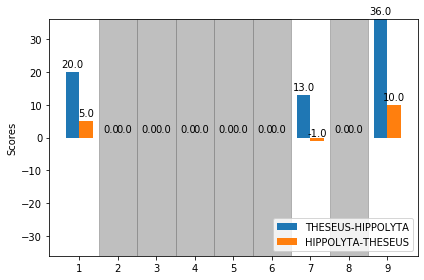

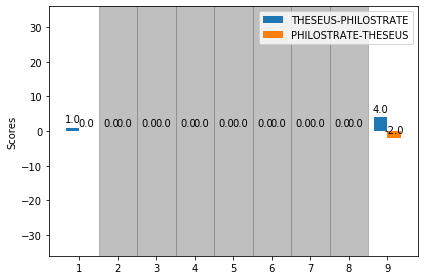

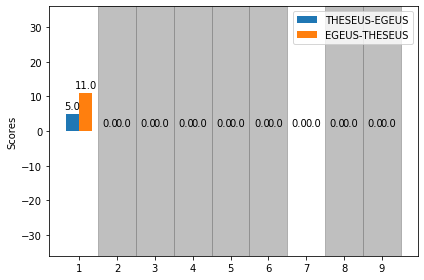

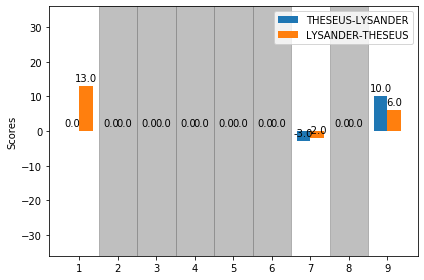

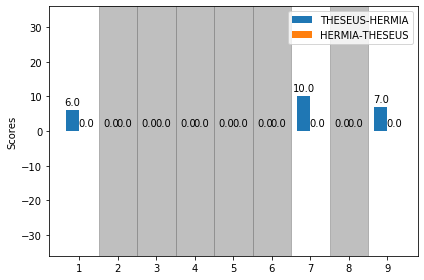

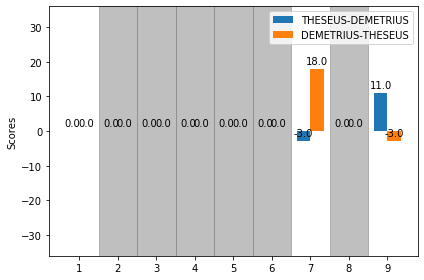

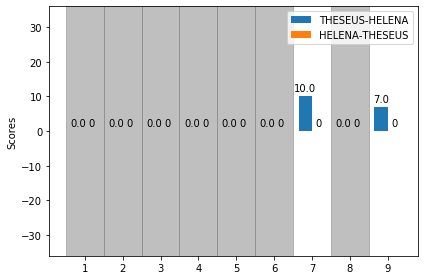

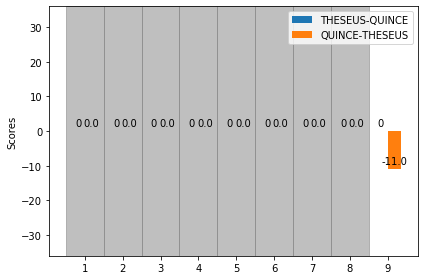

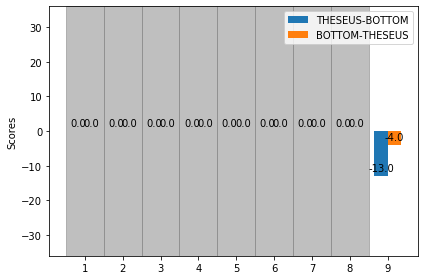

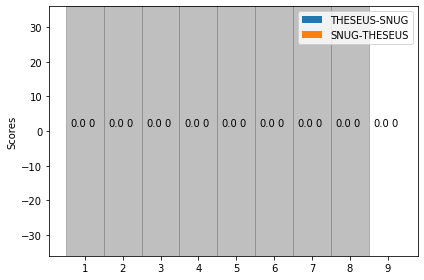

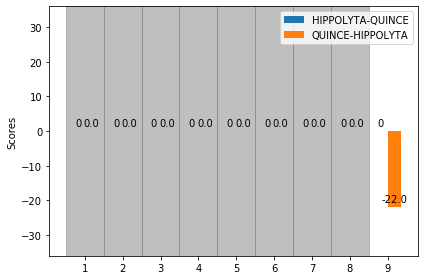

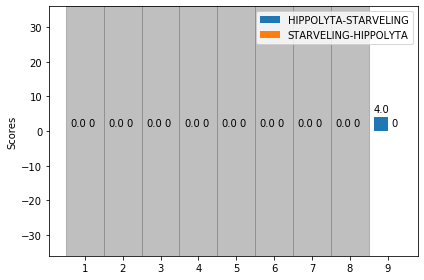

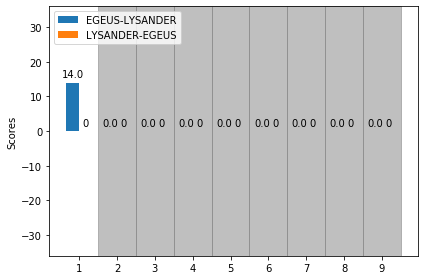

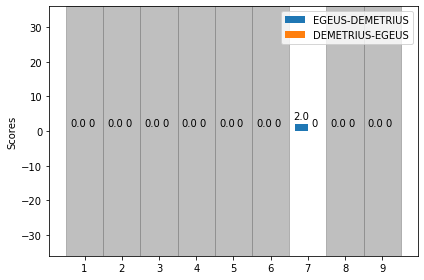

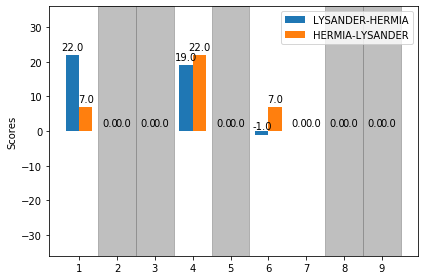

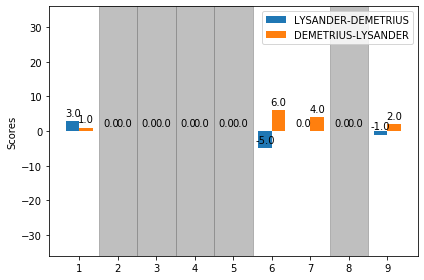

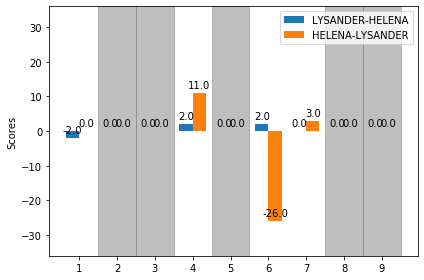

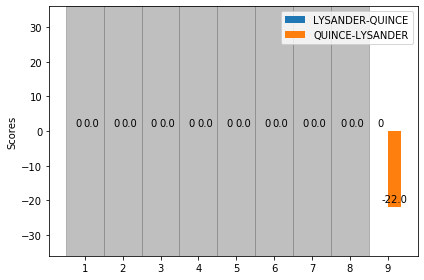

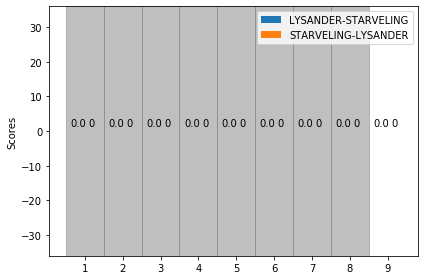

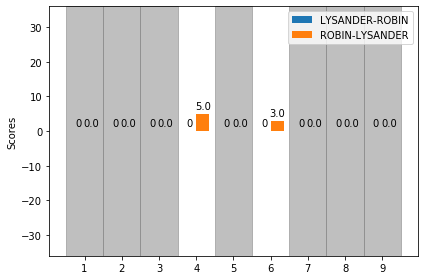

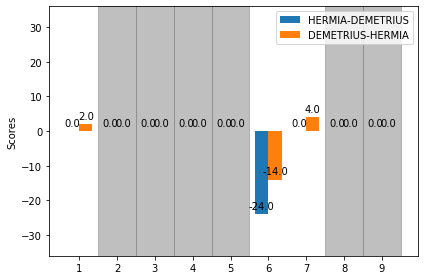

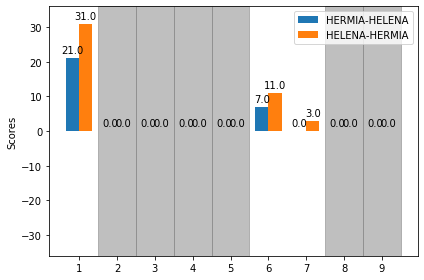

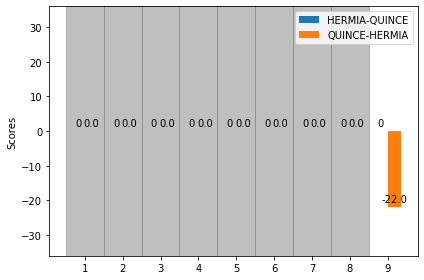

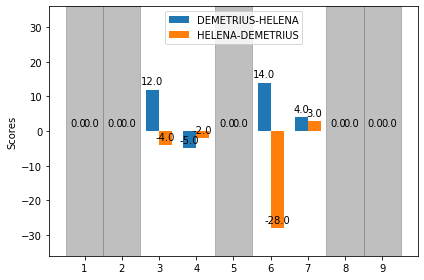

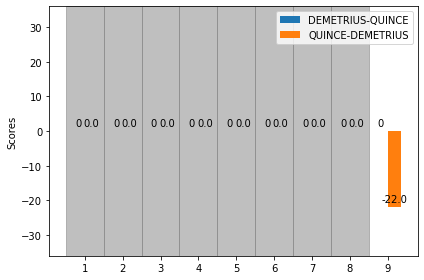

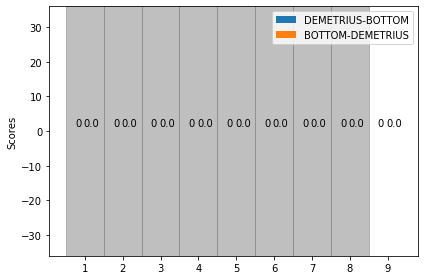

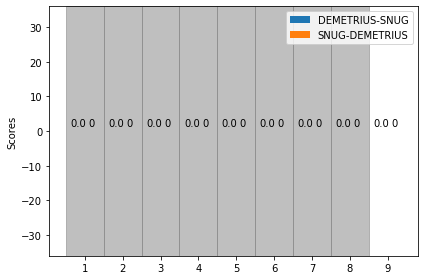

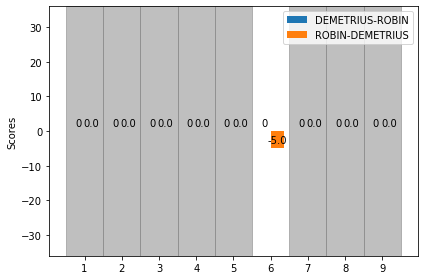

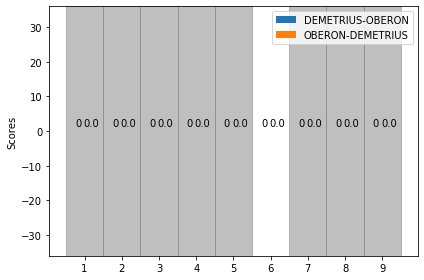

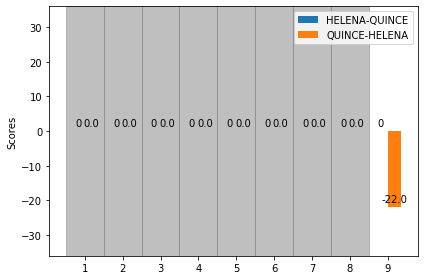

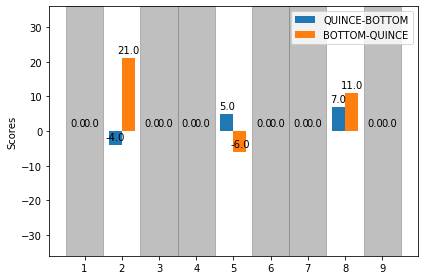

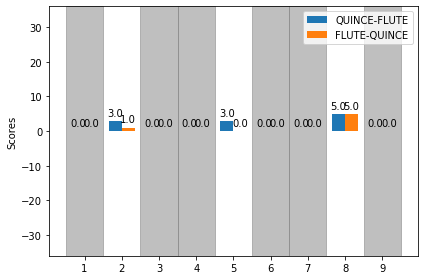

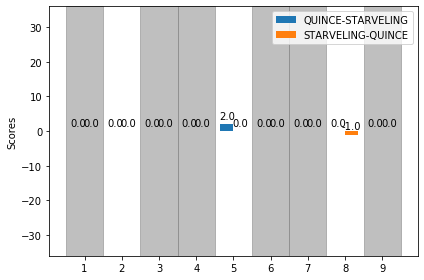

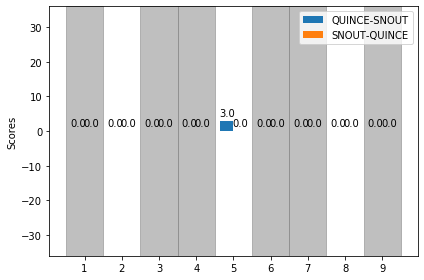

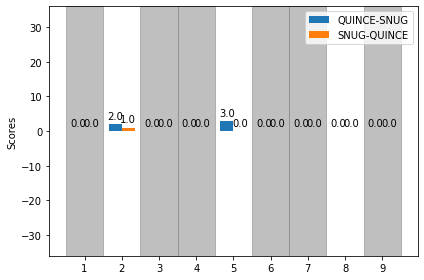

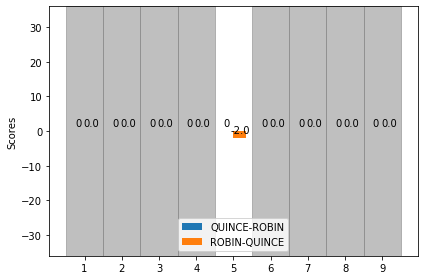

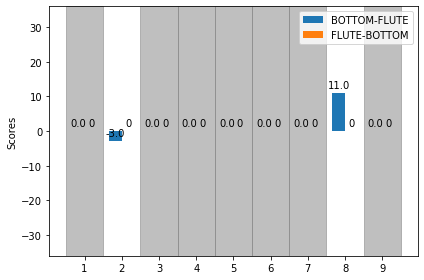

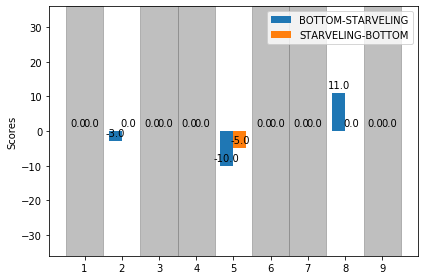

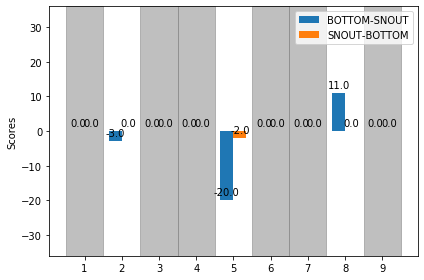

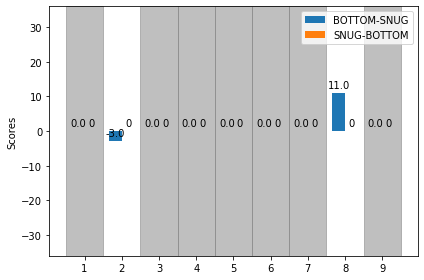

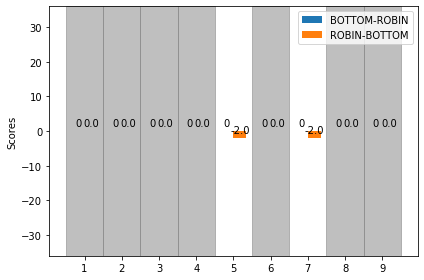

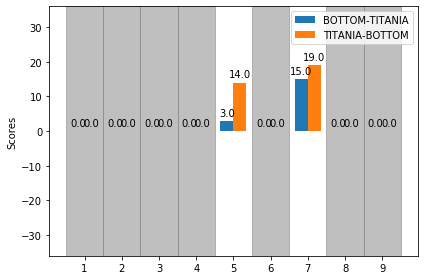

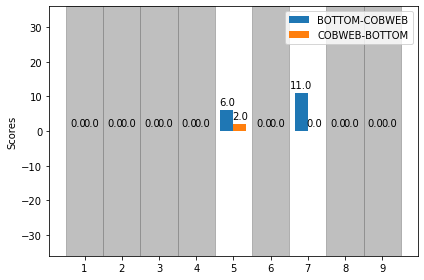

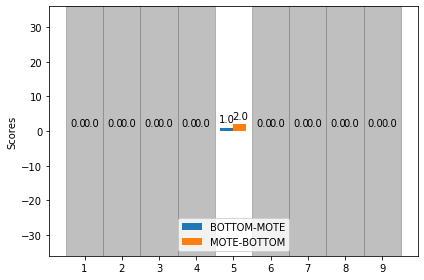

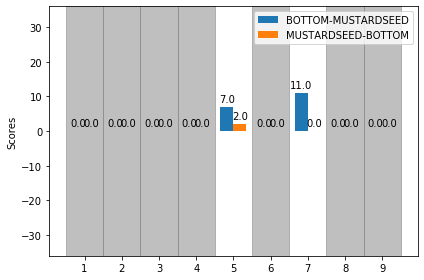

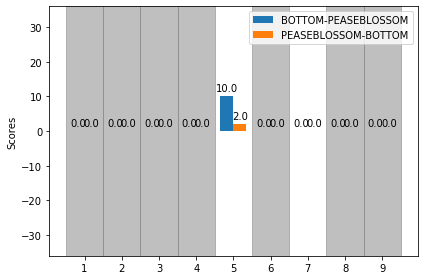

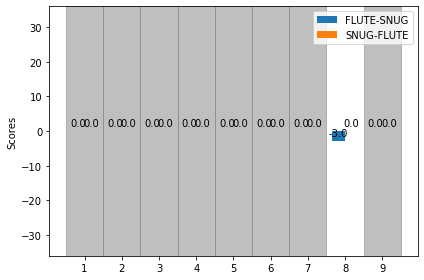

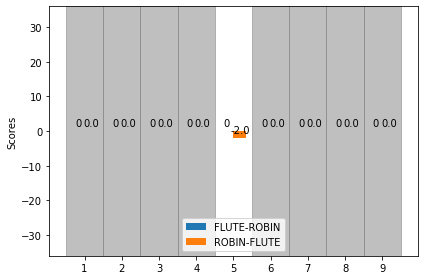

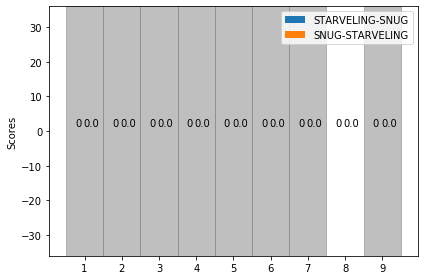

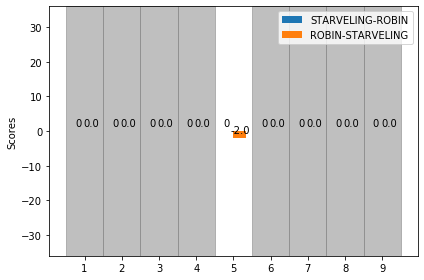

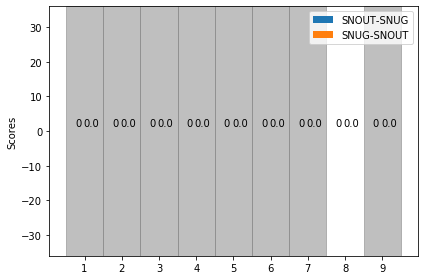

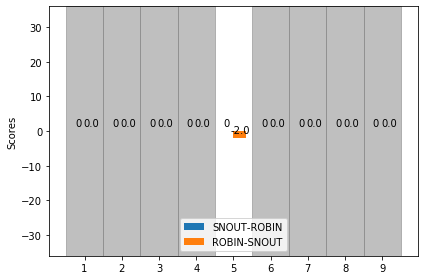

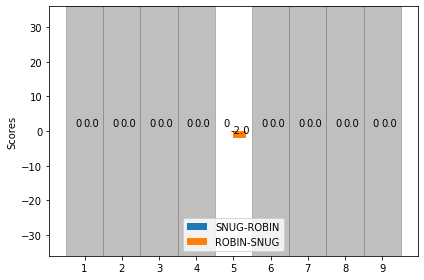

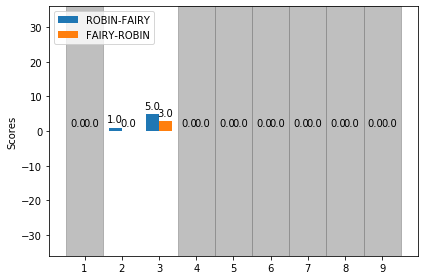

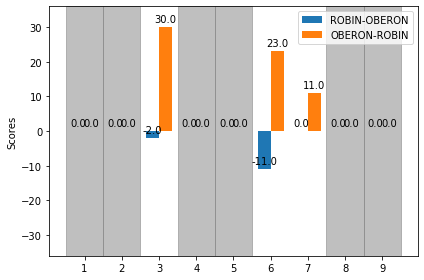

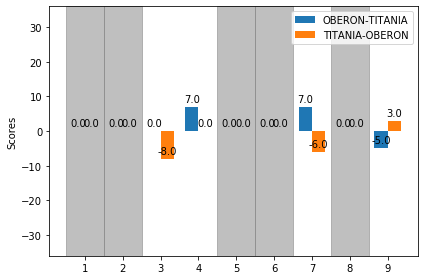

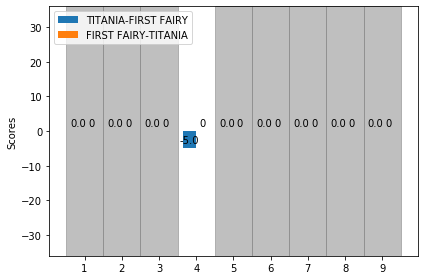

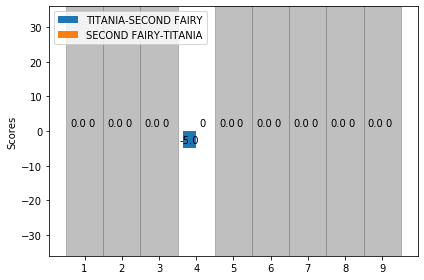

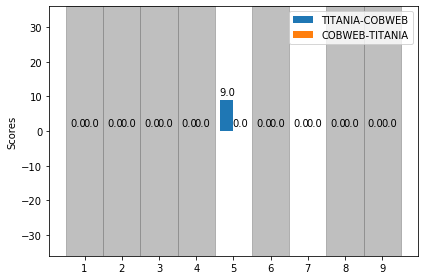

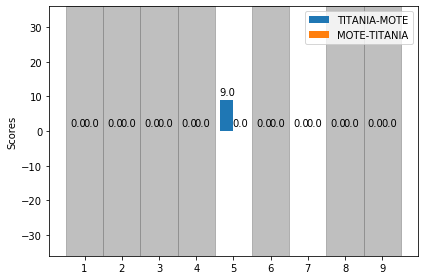

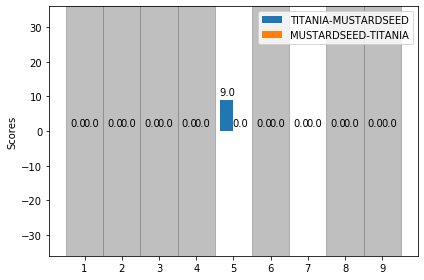

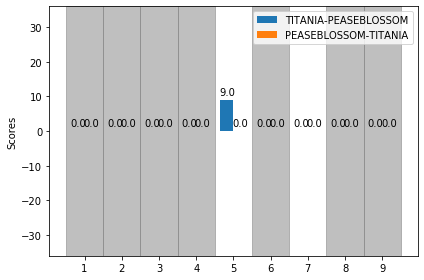

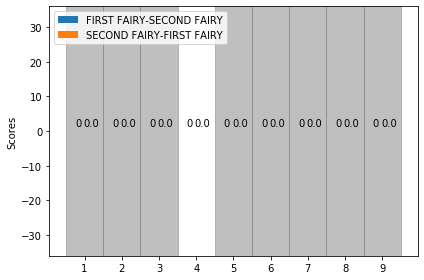

In [21]:
# Sample visualization
cplt, czplt, czpts = plotSentimentDict(S, SE, characters, plot=True)

In [22]:
print(cplt, czplt, czpts)

63 8 718


### Bing Liu lexicon

In [24]:
# Initialize sentiment dictionary for Bing Liu opinion lexicon

B = {}
BE = {}
for c1 in characters:
    for c2 in characters:
        if c1 != c2:
            B[(c1, c2)] = [0]*max_scene
            BE[(c1, c2)] = [0]*max_scene

In [25]:
# calculate sentiment valence for each dialogue and accumulate in dictionary.
# Note that this will take a long time because blscore() is very slow.

for i in range(1, sheet.nrows):
    row = sheet.row_values(i)
    speaker = row[0].split(', ')
    speech = row[1]
    recipient = row[2].split(', ')
    score = blscore(speech)
    for s in speaker:
        for r in recipient:
            if (s,r) in B:
                B[(s, r)][scene_num(i)] += score
                BE[(s, r)][scene_num(i)] += len(speech.split())

In [26]:
# Calculate stats on output
BLmaxS, BLminS, BLmaxE = valueRange(B, BE)
print(BLmaxS, BLminS, BLmaxE)

11 -14 545


In [27]:
# Filter out any pairs of characters that have no sentiment valence from dictionary (valence = 0 for all scenes)

norelationship = []
for key in BE:
    if BE[key] == [0]*max_scene:
        norelationship.append(key)
for key in norelationship:
    del B[key]
    del BE[key]

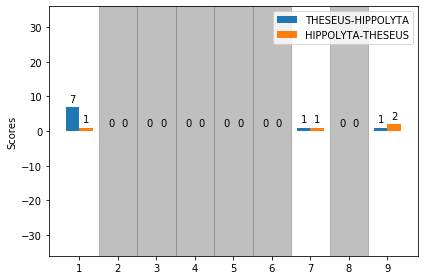

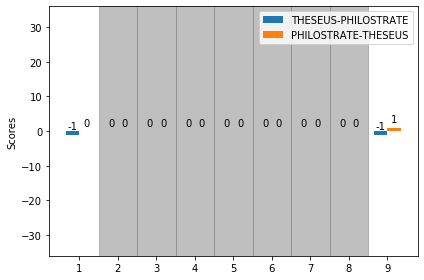

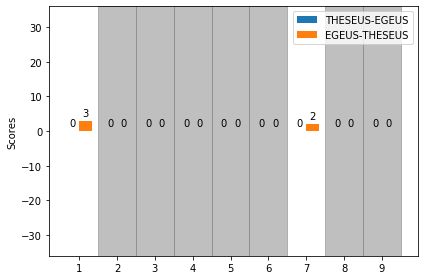

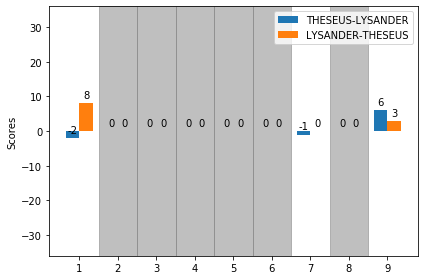

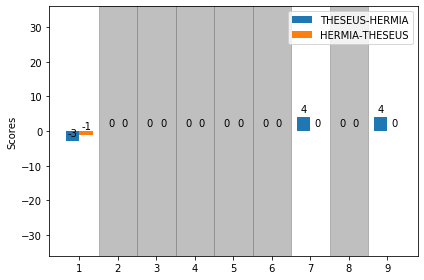

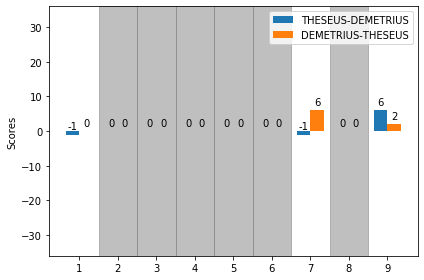

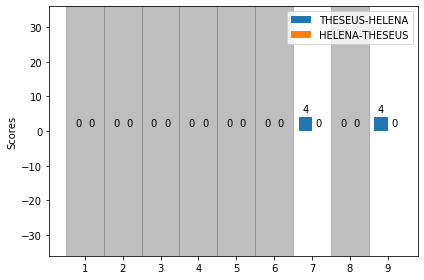

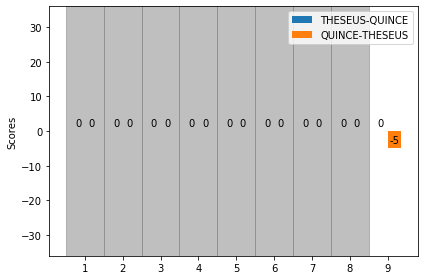

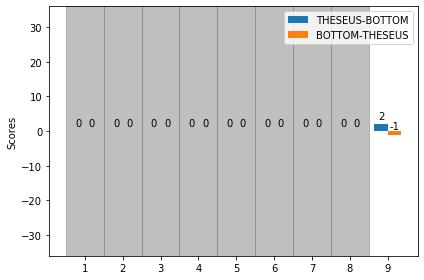

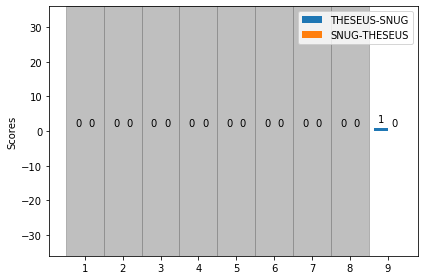

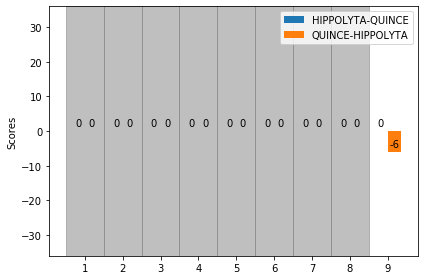

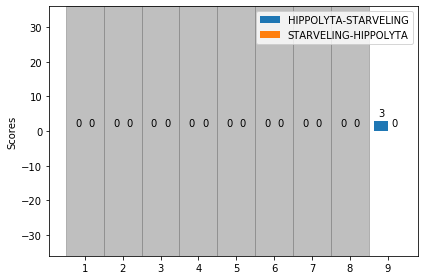

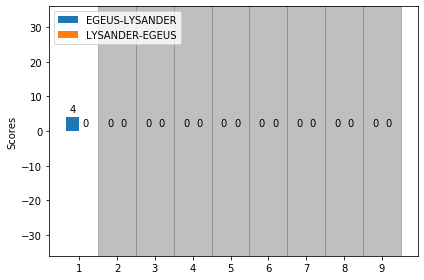

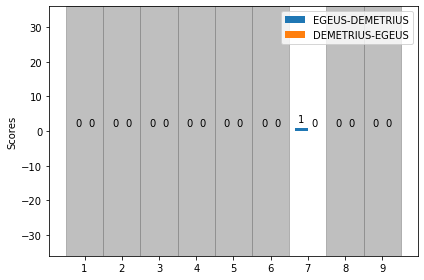

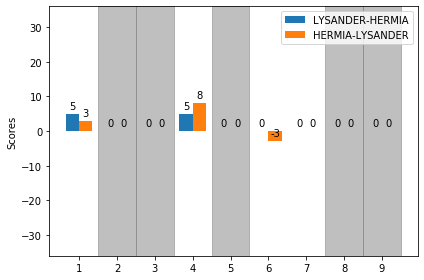

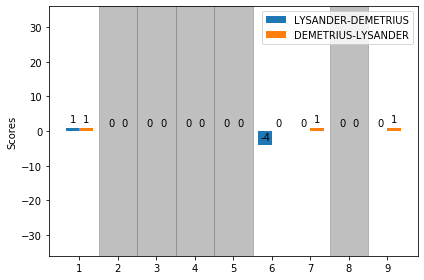

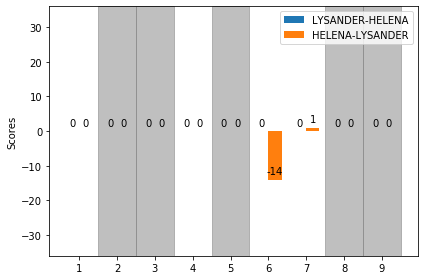

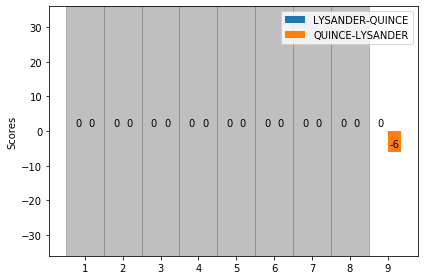

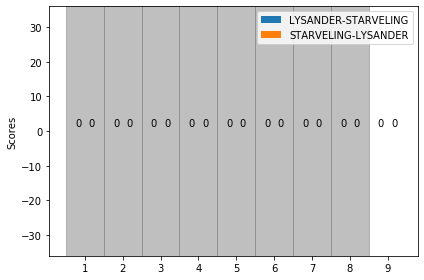

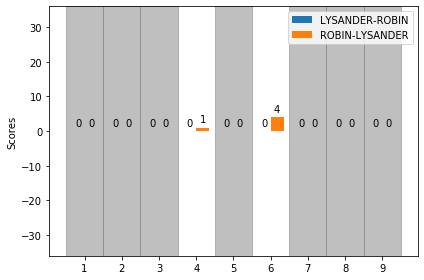

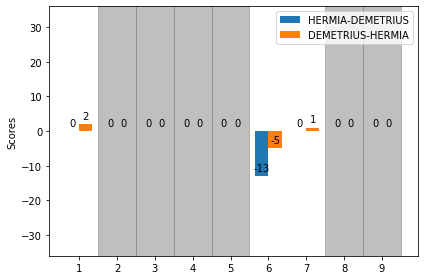

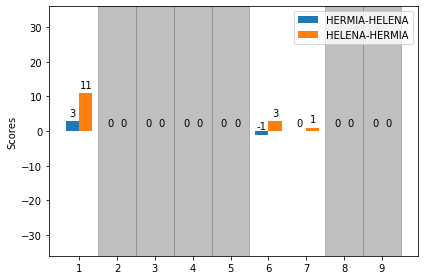

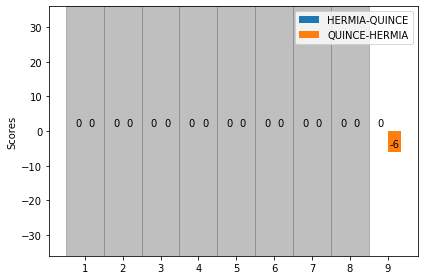

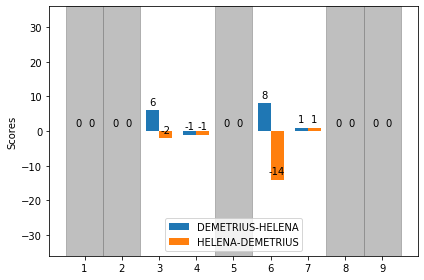

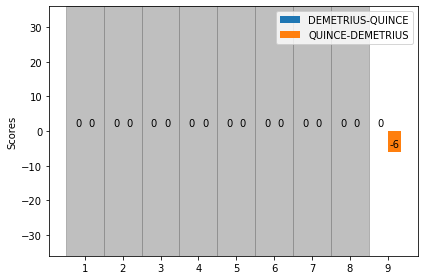

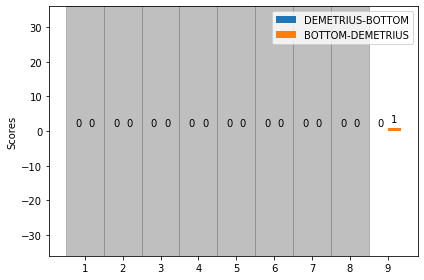

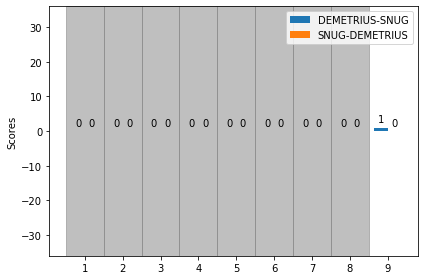

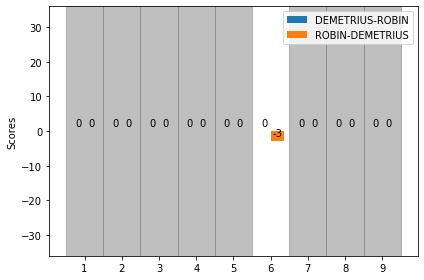

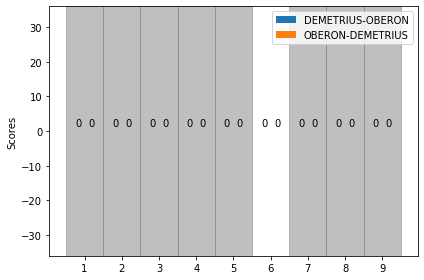

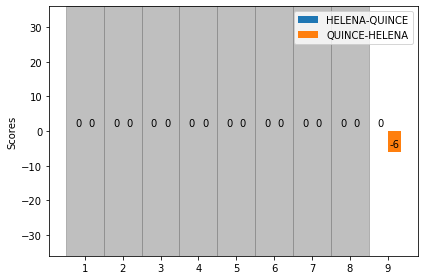

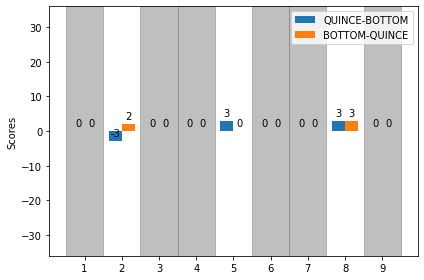

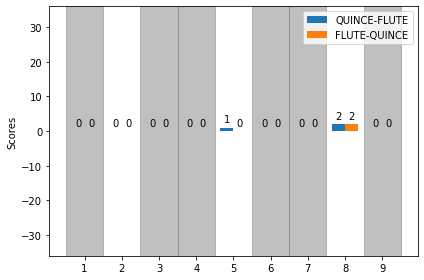

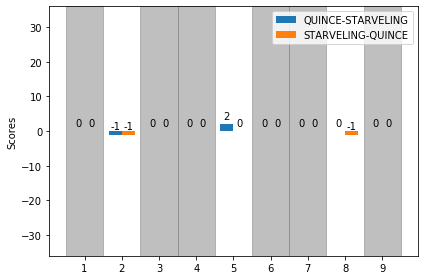

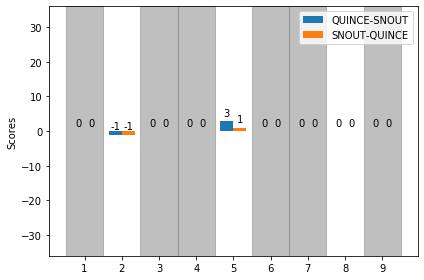

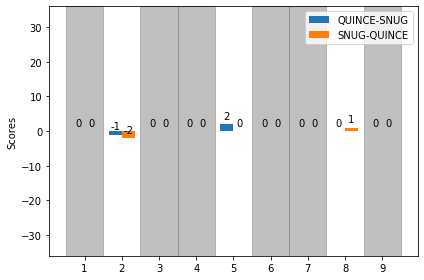

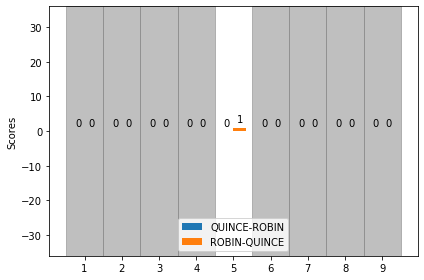

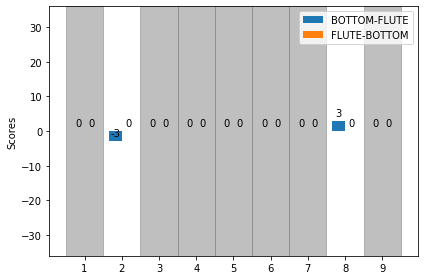

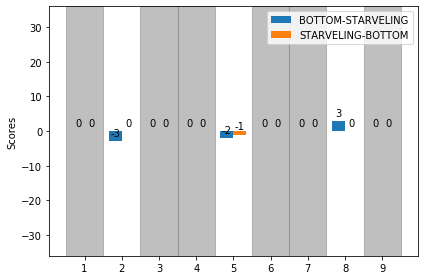

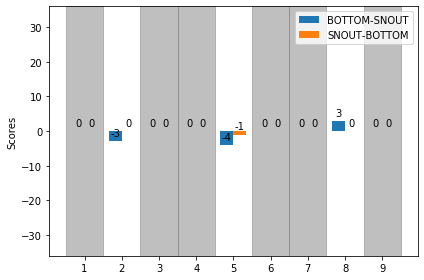

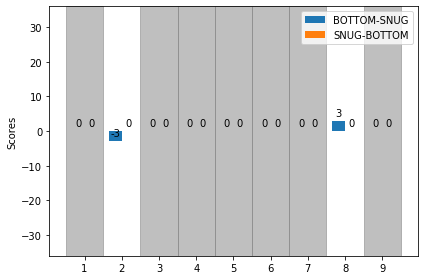

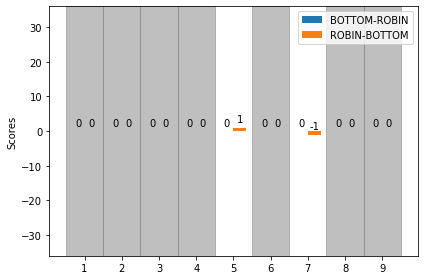

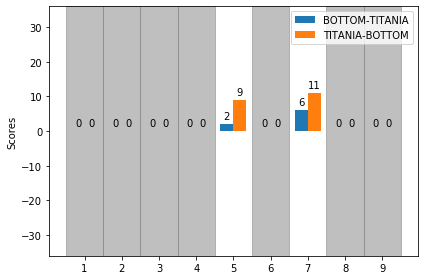

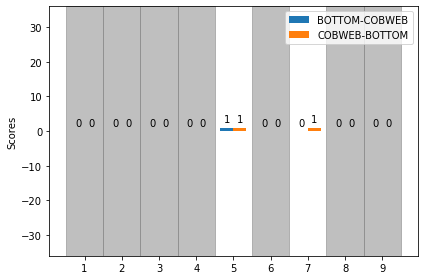

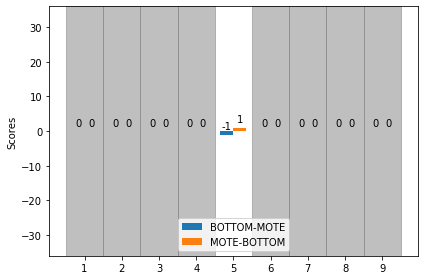

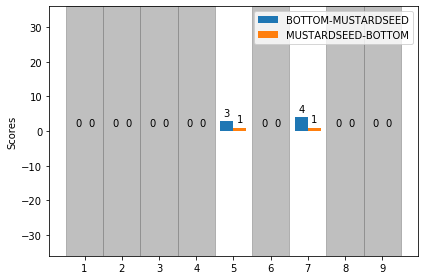

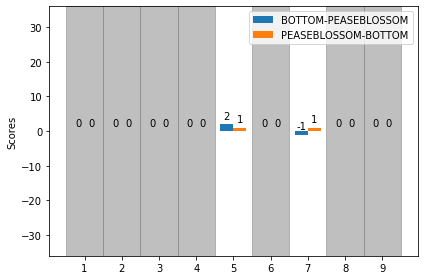

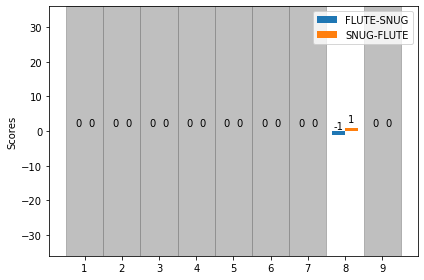

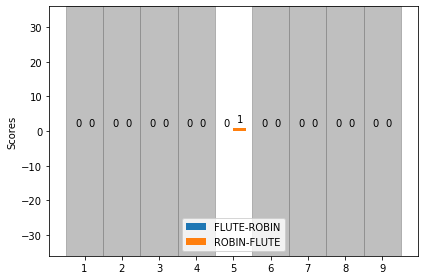

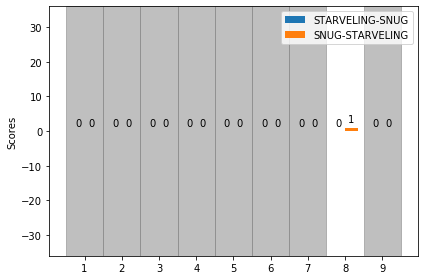

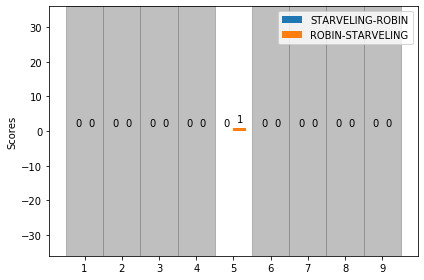

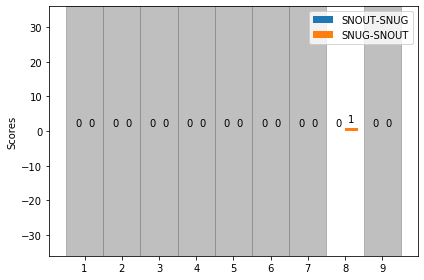

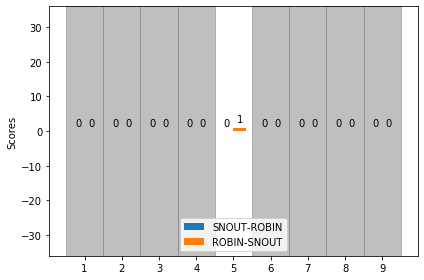

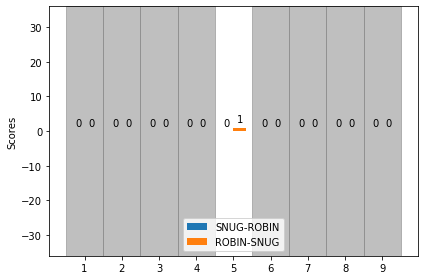

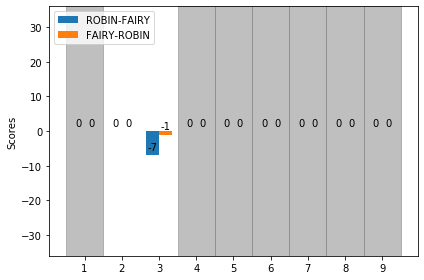

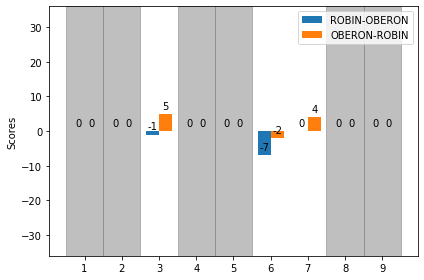

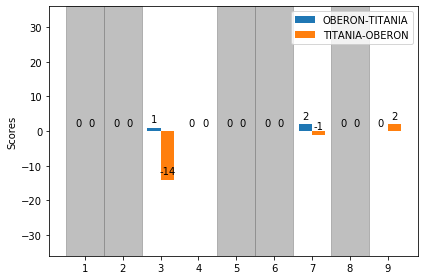

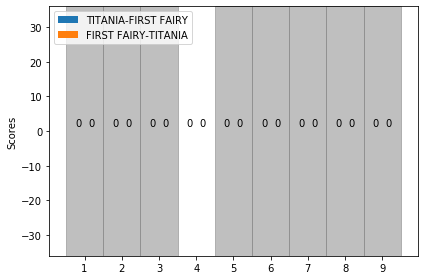

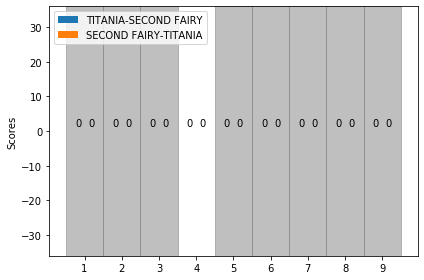

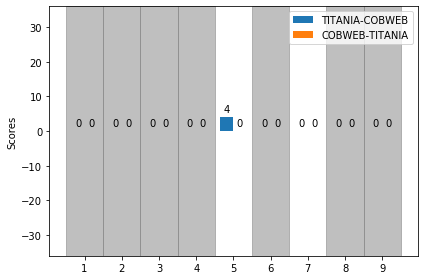

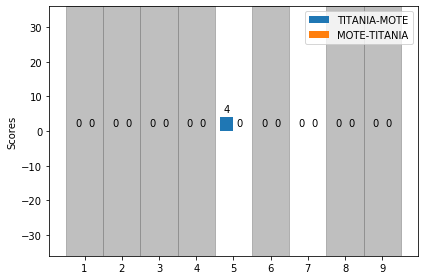

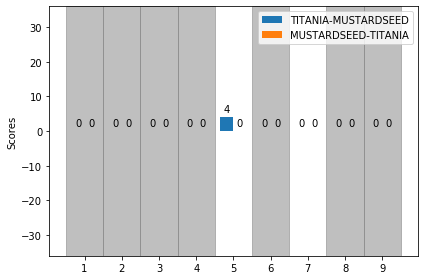

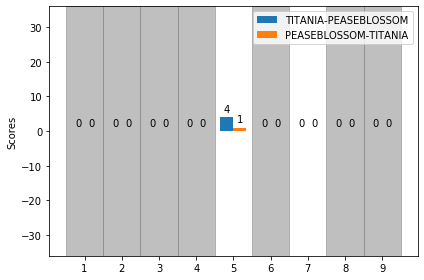

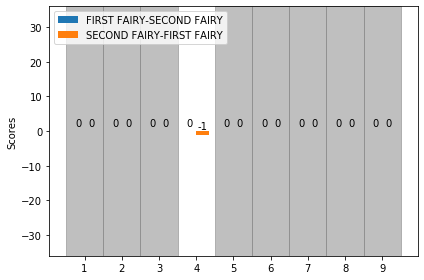

In [28]:
# Sample visualization
cplt, czplt, czpts = plotSentimentDict(B, BE, characters, plot=True)

In [29]:
cplt, czplt, czpts

(63, 4, 713)

## Write result to .ts file

The sentiment analysis data will be written to relationship_data.ts file to be visualized in relationship view.

In [31]:
# Result from AFINN lexicon

file = open("relationship_data.ts","w")
varAFINN = "export var sentiment_AFINN : { [id: string]: any; } = {"
for (c1, c2) in S:
    name = "\"" + c1 + "-" + c2 + "\"" #key
    
    #value string
    L = "["
    for i in range(len(S[(c1, c2)])):
        L = L + "{scene: " + str(i) + ", sentiment_value: " + str(S[(c1, c2)][i]) + ", speech_dist: " + str(SE[(c1, c2)][i]) + "},"
    L = L + "], "
    
    #add key-value pair to dictionary
    varAFINN = varAFINN + name + ":" + L
    
varAFINN = varAFINN[:-2] + "};"
file.write(varAFINN)
file.close()

In [32]:
# Result from Bing Liu lexicon

file = open("relationship_data.ts","a")
varBL = "export var sentiment_BL : { [id: string]: any; } = {"
for (c1, c2) in B:
    name = "\"" + c1 + "-" + c2 + "\"" #key
    
    #value string
    L = "["
    for i in range(len(B[(c1, c2)])):
        L = L + "{scene: " + str(i) + ", sentiment_value: " + str(B[(c1, c2)][i]) + ", speech_dist: " + str(BE[(c1, c2)][i]) + "},"
    L = L + "], "
    
    #add key-value pair to dictionary
    varBL = varBL + name + ":" + L
    
varBL = varBL[:-2] + "};"
file.write(varBL)
file.close()